In [1]:
import os
import pandas as pd
import sklearn.metrics
import numpy as np
import plotnine as p9
import optuna
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
TRIALS = 250
TOP_N = 1

In [3]:
def load_performance_metrics(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [4]:
text_length_df = pd.concat([
  pd.read_csv('../../data/text_properties/IMDb-top_1000/validation.csv').assign(dataset = 'IMDb-top_1000', split = 'validation'),
  pd.read_csv('../../data/text_properties/IMDb-top_1000/test.csv').assign(dataset = 'IMDb-top_1000', split = 'test'),
  pd.read_csv('../../data/text_properties/Ohsumed/validation.csv').assign(dataset = 'Ohsumed', split = 'validation'),
  pd.read_csv('../../data/text_properties/Ohsumed/test.csv').assign(dataset = 'Ohsumed', split = 'test'),
  pd.read_csv('../../data/text_properties/R8/validation.csv').assign(dataset = 'R8', split = 'validation'),
  pd.read_csv('../../data/text_properties/R8/test.csv').assign(dataset = 'R8', split = 'test'),
  pd.read_csv('../../data/text_properties/SST-2/validation.csv').assign(dataset = 'SST-2', split = 'validation'),
  pd.read_csv('../../data/text_properties/SST-2/test.csv').assign(dataset = 'SST-2', split = 'test')
])

In [5]:
def load_predictions(dataset, gnn, llm, method, aggregation, target_metric, display_information = False):
  metrics_df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = display_information)  
  best_trial, best_random_state = metrics_df.sort_values(by = ['split', target_metric], ascending = [True, False]).reset_index(drop = True).iloc[0][['trial', 'random_state']]
  return pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{best_trial}/{best_random_state}/predictions.csv')

In [6]:
predictions_df = pd.concat([
  load_predictions(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'IMDb-top_1000'),
  load_predictions(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'Ohsumed'),
  load_predictions(dataset = 'R8', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'f1_score', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'R8'),
  load_predictions(dataset = 'SST-2', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Surrogate', aggregation = 'No_Aggregation', target_metric = 'accuracy', display_information = False).sort_values(by = ['split', 'index']).reset_index(drop = True).assign(dataset = 'SST-2'),
])
predictions_df['correct'] = predictions_df['real'] == predictions_df['prediction']
predictions_df.drop(columns = ['real', 'prediction'], inplace = True)

In [7]:
combined_df = pd.merge(predictions_df, text_length_df, on = ['dataset', 'split', 'index']).drop(columns = ['index'])

In [8]:
imdb_df = combined_df[combined_df['dataset'] == 'IMDb-top_1000'].drop(columns = ['dataset', 'split'])
ohsumed_df = combined_df[combined_df['dataset'] == 'Ohsumed'].drop(columns = ['dataset', 'split'])
r8_df = combined_df[combined_df['dataset'] == 'R8'].drop(columns = ['dataset', 'split'])
sst_2_df = combined_df[combined_df['dataset'] == 'SST-2'].drop(columns = ['dataset', 'split'])

In [9]:
def prepare_features_for_edrs(df, target_column, q = 5):
  
  discretized_df = df.copy()

  for col in [x for x in discretized_df.columns if x != target_column]:
    
    col_df = discretized_df[[col]].copy()
    
    if df[col].dtype in [int, float]:
      col_df['q'], quantile_intervals = pd.qcut(col_df[col], q = q, retbins = True, duplicates = 'drop')
      
      quantile_interval_labels = [f'({np.round(quantile_intervals[i], decimals = 3)} - {np.round(quantile_intervals[i + 1], decimals = 3)}]' for i in range(len(quantile_intervals) - 1)]
      col_df['q'] = col_df['q'].cat.rename_categories(quantile_interval_labels)
      
      # Add quantile_interval_labels to 'q' column
      col_df['q'] = pd.Categorical(col_df['q'], categories = quantile_interval_labels, ordered = True)
    else:
      col_df['q'] = pd.Categorical(col_df[col], categories = col_df[col].unique(), ordered = True)
    
    discretized_df[col] = col_df['q']

  return discretized_df

In [10]:
imdb_df_discrete = prepare_features_for_edrs(imdb_df, target_column = 'correct', q = 5)
ohsumed_df_discrete = prepare_features_for_edrs(ohsumed_df, target_column = 'correct', q = 5)
r8_df_discrete = prepare_features_for_edrs(r8_df, target_column = 'correct', q = 5)
sst_2_df_discrete = prepare_features_for_edrs(sst_2_df, target_column = 'correct', q = 5)

In [11]:
imdb_df_discrete['correct'] = imdb_df_discrete.pop('correct')
ohsumed_df_discrete['correct'] = ohsumed_df_discrete.pop('correct')
r8_df_discrete['correct'] = r8_df_discrete.pop('correct')
sst_2_df_discrete['correct'] = sst_2_df_discrete.pop('correct')

In [12]:
imdb_df_discrete.to_csv('./data/IMDb-top_1000.csv', index = False)
ohsumed_df_discrete.to_csv('./data/Ohsumed.csv', index = False)
r8_df_discrete.to_csv('./data/R8.csv', index = False)
sst_2_df_discrete.to_csv('./data/SST-2.csv', index = False)

# Subgroup visualization

In [12]:
# Subgroups mined using CAREN 2.6.4 (https://www.di.uminho.pt/~pja/class/caren.html)

# java caren /PATH/TO/DISCRETIZED/dataset.csv 0.1 0.5 -Att -s, -imp0.001 -Hcorrect -ocs/OUTPUT/PATH/filename

# Both support (0.1 in example) and confidence (0.5 in example) matter
# Last rule is to be ignored

In [13]:
# CAREN is throwing an error with IMDb... # java caren /Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/data/IMDb-top_1000.csv 0.15 0.65 -Att -s, -imp0.001 -Hcorrect -ocs/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/IMDb-top_1000
# java caren /Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/data/Ohsumed.csv 0.15 0.65 -Att -s, -imp0.001 -Hcorrect -ocs/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/Ohsumed
# java caren /Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/data/R8.csv 0.15 0.65 -Att -s, -imp0.001 -Hcorrect -ocs/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/R8
# java caren /Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/data/SST-2.csv 0.15 0.65 -Att -s, -imp0.001 -Hcorrect -ocs/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/SST-2

In [37]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def get_arules(dataset, support = 0.15, confidence = 0.65):
  df = pd.read_csv(f'/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/data/{dataset}.csv')
  for col in df.columns:
    df[col] = df[col].astype(str).map(lambda x : col + ' = ' + x)
  data = df.values.tolist()

  te = TransactionEncoder()
  te_ary = te.fit(data).transform(data)
  df = pd.DataFrame(te_ary, columns = te.columns_)

  frequent_itemsets = apriori(df, min_support = support, use_colnames = True)

  rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = confidence)
  return rules[rules['consequents'].map(lambda x : 'correct = ' in str(x) and len(x) == 1)]

In [40]:
pd.concat([
  get_arules('IMDb-top_1000'),
  get_arules('Ohsumed'),
  get_arules('R8'),
  get_arules('SST-2')
]).duplicated(subset = ['antecedents', 'consequents'], keep = False).value_counts()

False    176
dtype: int64

In [83]:
subgroups = pd.concat([
  #pd.read_csv('/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/IMDb-top_1000.csv', sep = ';')[['Ant', 'Cons', 'Sup', 'Conf']].assign(dataset = 'IMDb-top_1000'),
  pd.read_csv('/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/Ohsumed.csv', sep = ';')[['Ant', 'Cons', 'Sup', 'Conf']].assign(dataset = 'Ohsumed'),
  pd.read_csv('/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/R8.csv', sep = ';')[['Ant', 'Cons', 'Sup', 'Conf']].assign(dataset = 'R8'),
  pd.read_csv('/Users/joaopimentel/Documents/GitHub/LLM_token_graphs/analyses/performance/subgroups/SST-2.csv', sep = ';')[['Ant', 'Cons', 'Sup', 'Conf']].assign(dataset = 'SST-2')
])

In [84]:
all_data_subgroups = subgroups[subgroups['Ant'].isna()]
subgroups = subgroups[~subgroups['Ant'].isna()]


In [85]:
subgroups['Cons'] = subgroups['Cons'].apply(lambda x : x.replace('correct=', '') == 'True')
subgroups.rename(columns = {'Cons' : 'correct', 'Sup' : 'support', 'Conf' : 'confidence', 'Ant' : 'subgroup'}, inplace = True)
l = list()
for s in subgroups.iterrows():
  l.append({'subgroup' : s[1]['subgroup'], 'correct' : not s[1]['correct'], 'support' : s[1]['support'], 'confidence' : 1 - s[1]['confidence'], 'dataset' : s[1]['dataset']})
subgroups = pd.concat([subgroups, pd.DataFrame(l)], ignore_index = True)
subgroups['subgroup'] = subgroups['subgroup'].apply(lambda x : x.replace('  &  ', ', ').replace(' - ', ', '))

In [86]:
all_data_subgroups['Cons'] = all_data_subgroups['Cons'].apply(lambda x : x.replace('correct=', '') == 'True')
all_data_subgroups.rename(columns = {'Cons' : 'correct', 'Conf' : 'confidence'}, inplace = True)
l = list()
for s in all_data_subgroups.iterrows():
  l.append({'subgroup' : 'All data', 'correct' : s[1]['correct'], 'support' : 1.0, 'confidence' : s[1]['confidence'], 'dataset' : s[1]['dataset']})
  l.append({'subgroup' : 'All data', 'correct' : not s[1]['correct'], 'support' : 1.0, 'confidence' : 1 - s[1]['confidence'], 'dataset' : s[1]['dataset']})
all_data_subgroups = pd.DataFrame(l)

In [87]:
plot_df = pd.concat([subgroups, all_data_subgroups])
plot_df['subgroup'] = pd.Categorical(plot_df['subgroup'], categories = subgroups['subgroup'].sort_values(ascending = False).unique().tolist() + ['All data'])

In [88]:
subgroups.duplicated(subset = ['subgroup', 'correct'], keep = False).value_counts()

False    270
dtype: int64

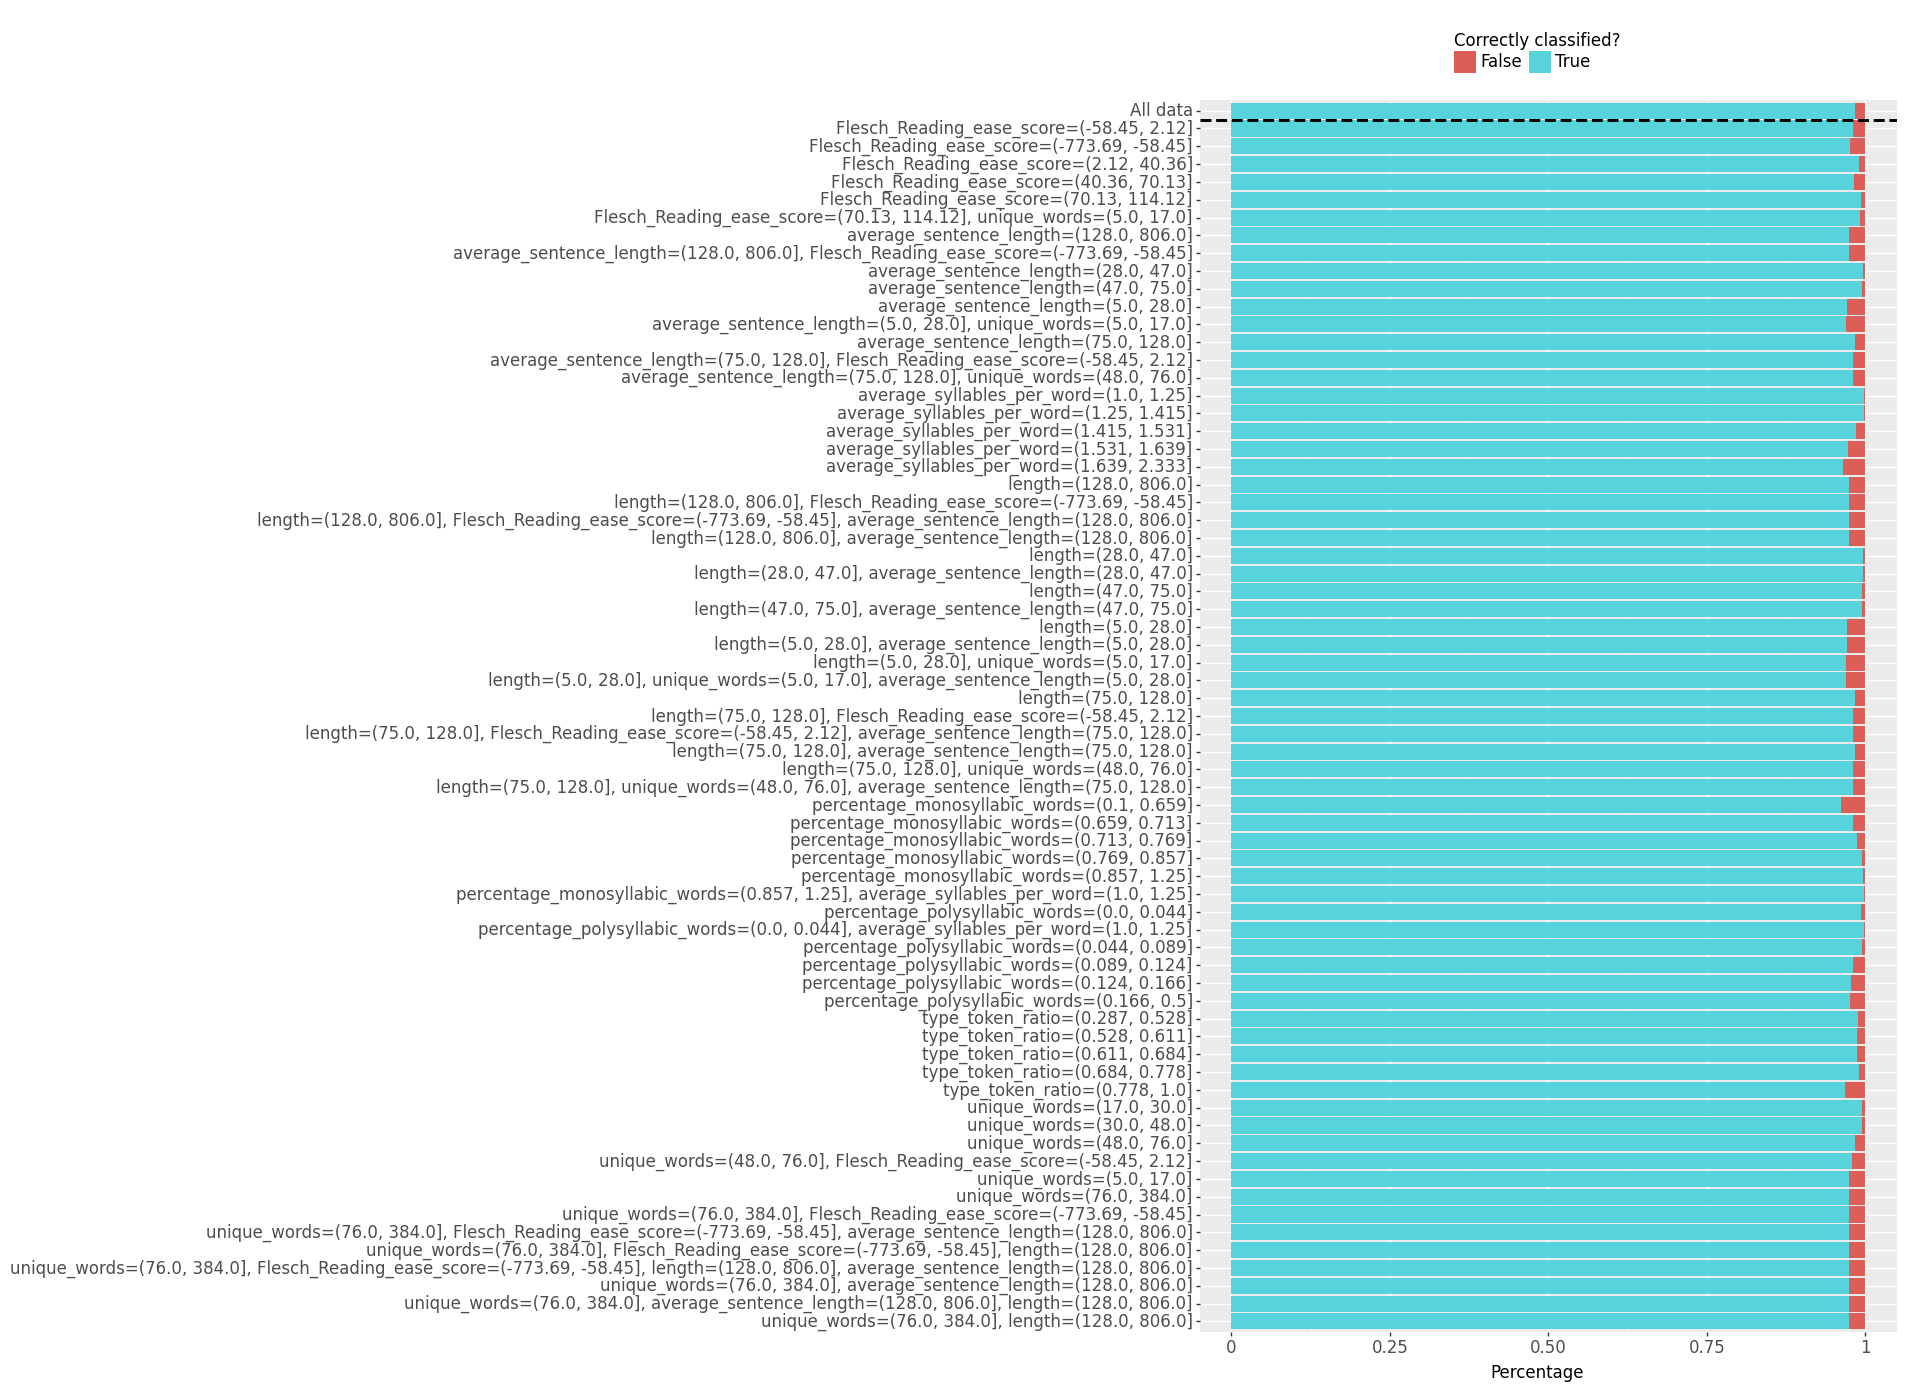

<ggplot: (402204417)>

In [89]:
p9.ggplot(
  plot_df[plot_df['dataset'] == 'R8'],
  p9.aes(x = 'subgroup', y = 'confidence', fill = 'correct')
) + \
  p9.geom_col() + \
  p9.geom_vline(xintercept = subgroups[subgroups['dataset'] == 'R8']['subgroup'].nunique() + 0.5, linetype = 'dashed', size = 1.2) + \
  p9.ylab('Percentage') + \
  p9.xlab('') + \
  p9.labs(fill = 'Correctly classified?') + \
  p9.theme_gray() + \
  p9.coord_flip() + \
  p9.theme(
    legend_position = 'top',
    figure_size = (9, 16),
    text = p9.element_text(size = 12)
  )

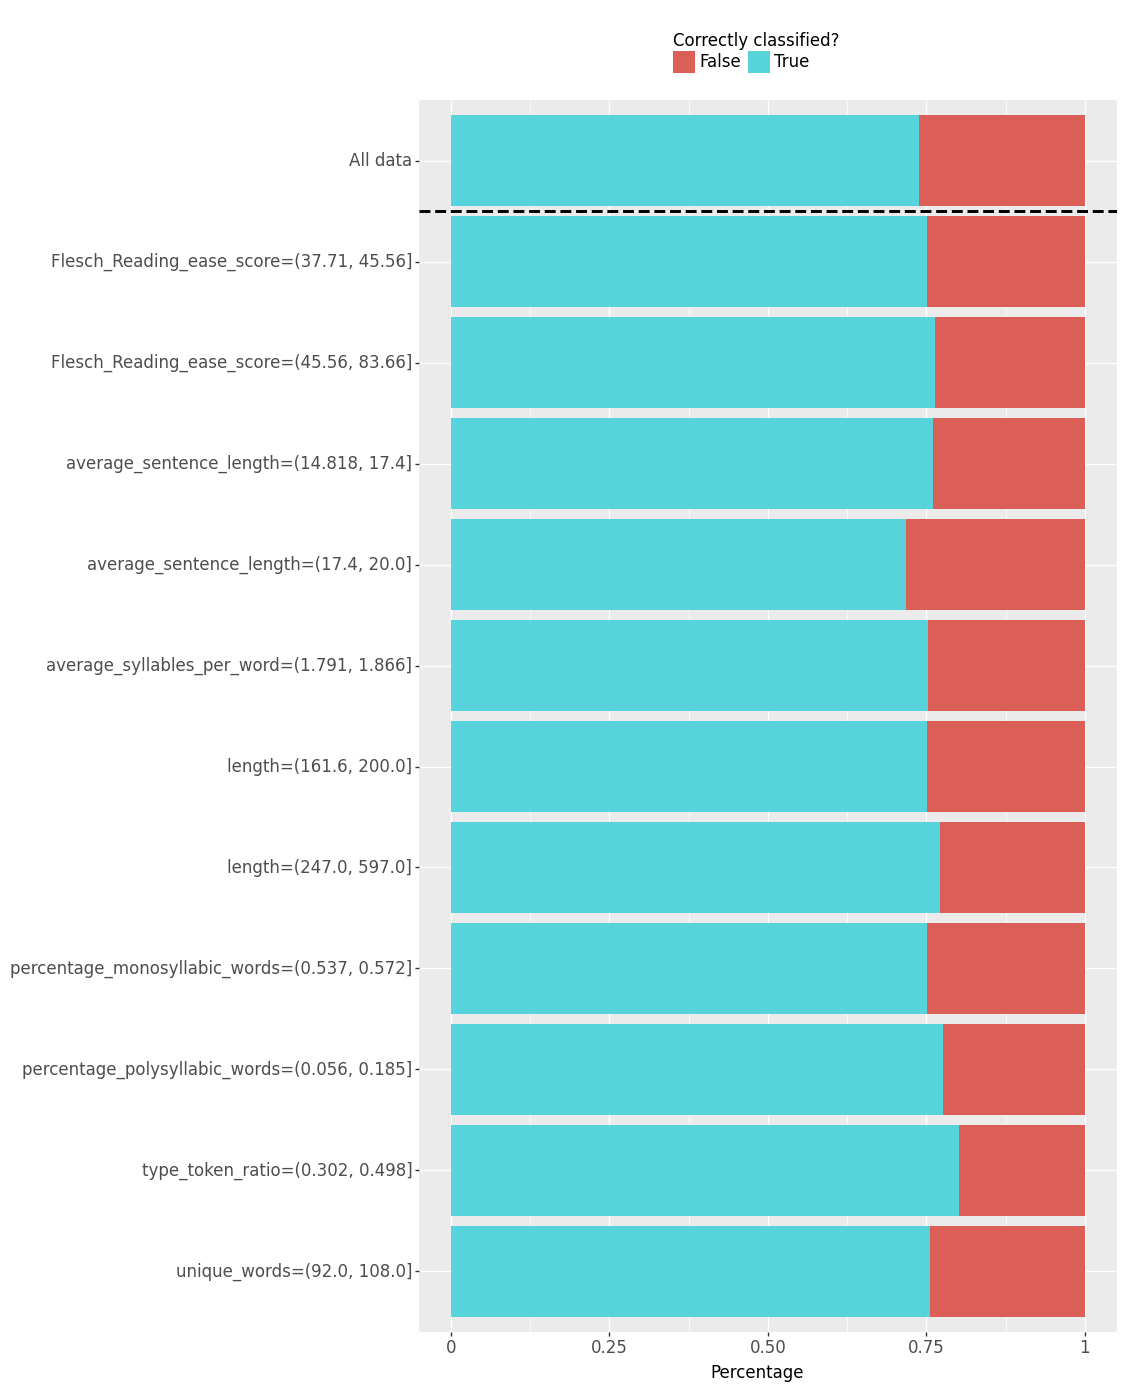

<ggplot: (402077282)>

In [90]:
p9.ggplot(
  plot_df[plot_df['dataset'] == 'Ohsumed'],
  p9.aes(x = 'subgroup', y = 'confidence', fill = 'correct')
) + \
  p9.geom_col() + \
  p9.geom_vline(xintercept = subgroups[subgroups['dataset'] == 'Ohsumed']['subgroup'].nunique() + 0.5, linetype = 'dashed', size = 1.2) + \
  p9.ylab('Percentage') + \
  p9.xlab('') + \
  p9.labs(fill = 'Correctly classified?') + \
  p9.theme_gray() + \
  p9.coord_flip() + \
  p9.theme(
    legend_position = 'top',
    figure_size = (9, 16),
    text = p9.element_text(size = 12)
  )

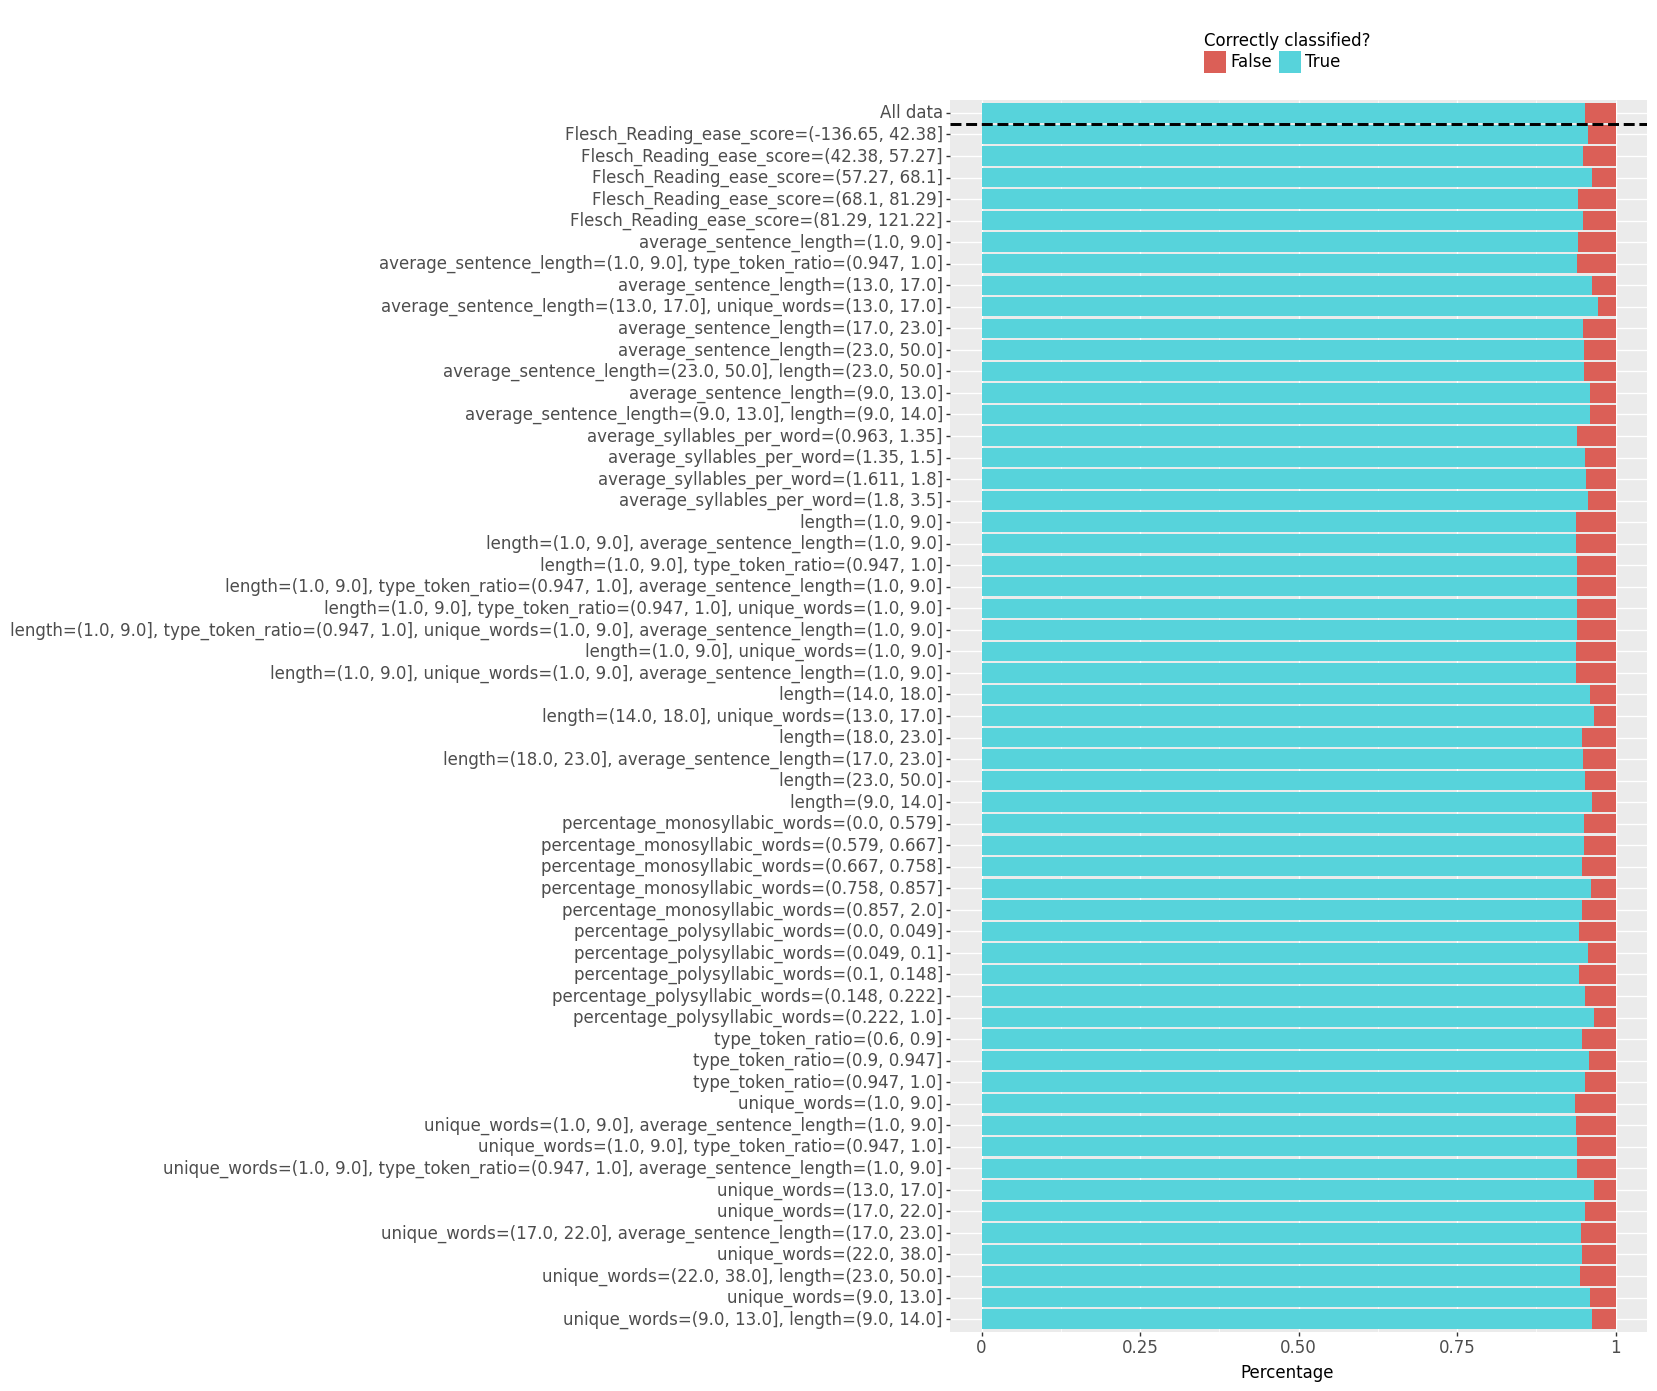

<ggplot: (402024184)>

In [91]:
p9.ggplot(
  plot_df[plot_df['dataset'] == 'SST-2'],
  p9.aes(x = 'subgroup', y = 'confidence', fill = 'correct')
) + \
  p9.geom_col() + \
  p9.geom_vline(xintercept = subgroups[subgroups['dataset'] == 'SST-2']['subgroup'].nunique() + 0.5, linetype = 'dashed', size = 1.2) + \
  p9.ylab('Percentage') + \
  p9.xlab('') + \
  p9.labs(fill = 'Correctly classified?') + \
  p9.theme_gray() + \
  p9.coord_flip() + \
  p9.theme(
    legend_position = 'top',
    figure_size = (9, 16),
    text = p9.element_text(size = 12)
  )